In [ ]:
from google.colab import files
import io
import pandas as pd
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['1001.csv']))

Saving 1001.csv to 1001 (1).csv


RangeIndex(start=0, stop=659, step=1)

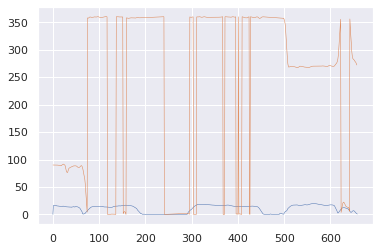

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size

data.set_index("time_seconds")
data['speed_meters_per_second'].plot(linewidth=0.5)
data['heading_degrees'].plot(linewidth=0.5)
data.index


In [ ]:

import math
def count_turns_stops(df):
  try:
    deg=45
    bins=10
    df["present"]=df["heading_degrees"]
    df=df.apply(pd.to_numeric)
    df.fillna(0,inplace=True)
    df=df[list(df.columns)].astype(int)
    # Considering every event within 3 seconds to be same - taking (3)average and selecting every 3rd row
    df=df.rolling(bins).mean() 
    df = df.iloc[::bins, :]
    df=df.apply(pd.to_numeric)
    df.fillna(0,inplace=True)
    df=df[list(df.columns)].astype(int)
    # Considering every event within 3 seconds to be same
    df.fillna(0,inplace=True)
    #Left & right turns
    df['turn_count'] = ((df.present.shift(1) - df.present).abs() > deg) &  (df.present.shift(-1) == df.present)
    df['turn_count']|=((df.present.shift(-1) - df.present).abs() > deg) &  (df.present.shift(1) == df.present) 
    #peak turns
    df['turn_count']|=((df.present.shift(-1) - df.present).abs() > deg) &  ((df.present.shift(1) - df.present).abs() >deg)
    #count_stops
    df["stop_count"]=(df.speed_meters_per_second.shift(-1) == df.speed_meters_per_second) &  (df.speed_meters_per_second.shift(1) == df.speed_meters_per_second)
    #df.to_csv("f.csv")
    #files.download("f.csv")
    return len(df[df.turn_count==True]),len(df[df.speed_meters_per_second==True]),df
  except Exception as e:
    print(e)
    return 0,0,None
  
nturns,nstops,data2=count_turns_stops(data)
print(nturns,nstops)


22 1


# Feature Extraction :
* Count of Turns
* Count of Stops

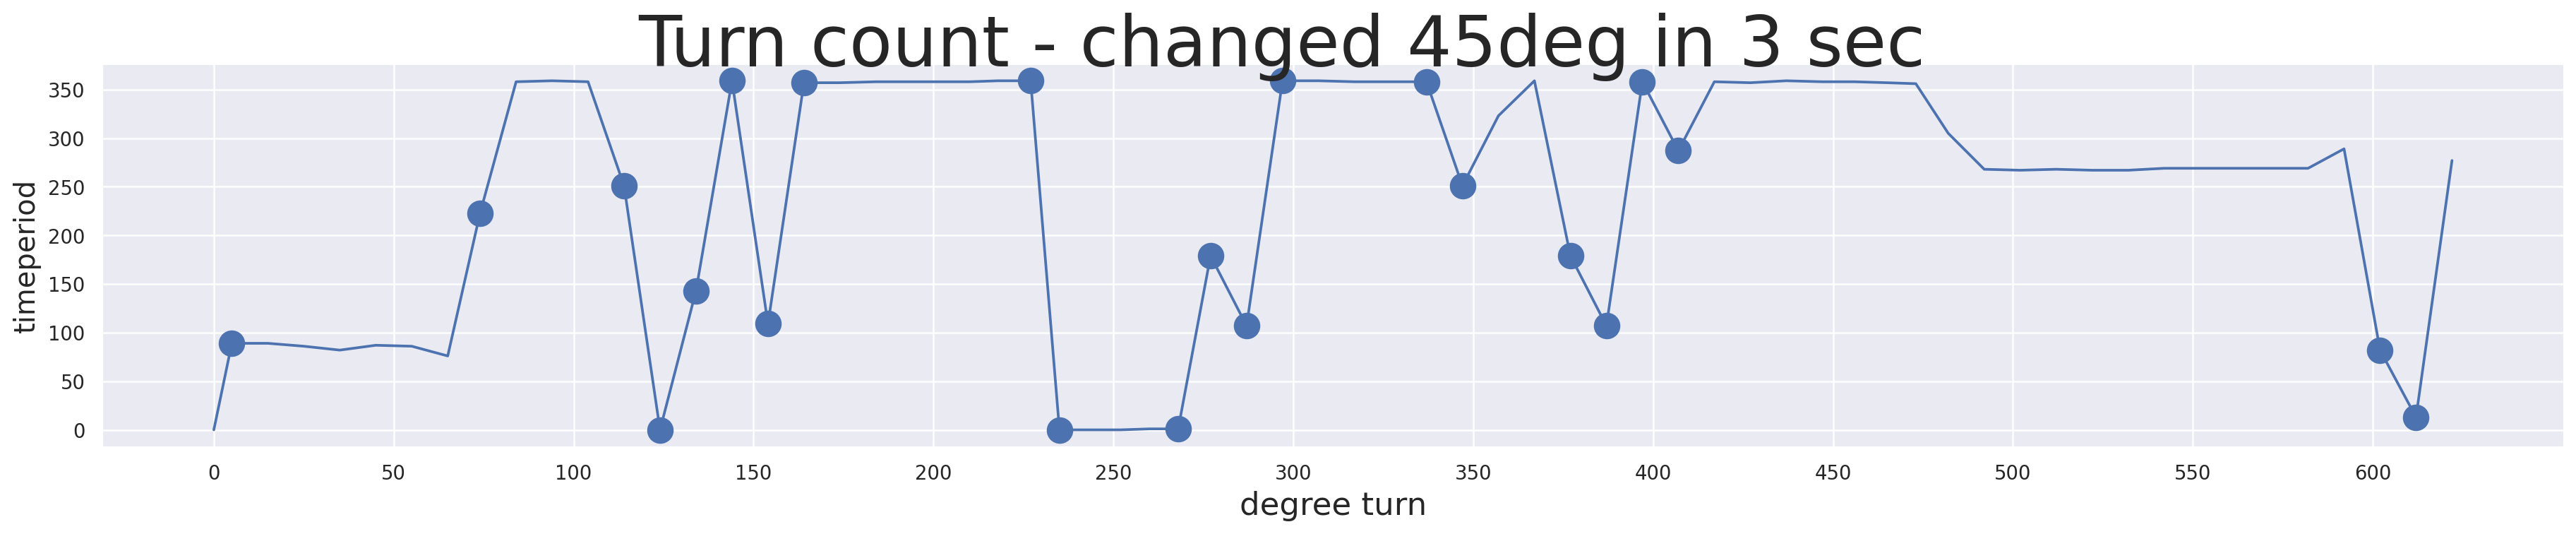

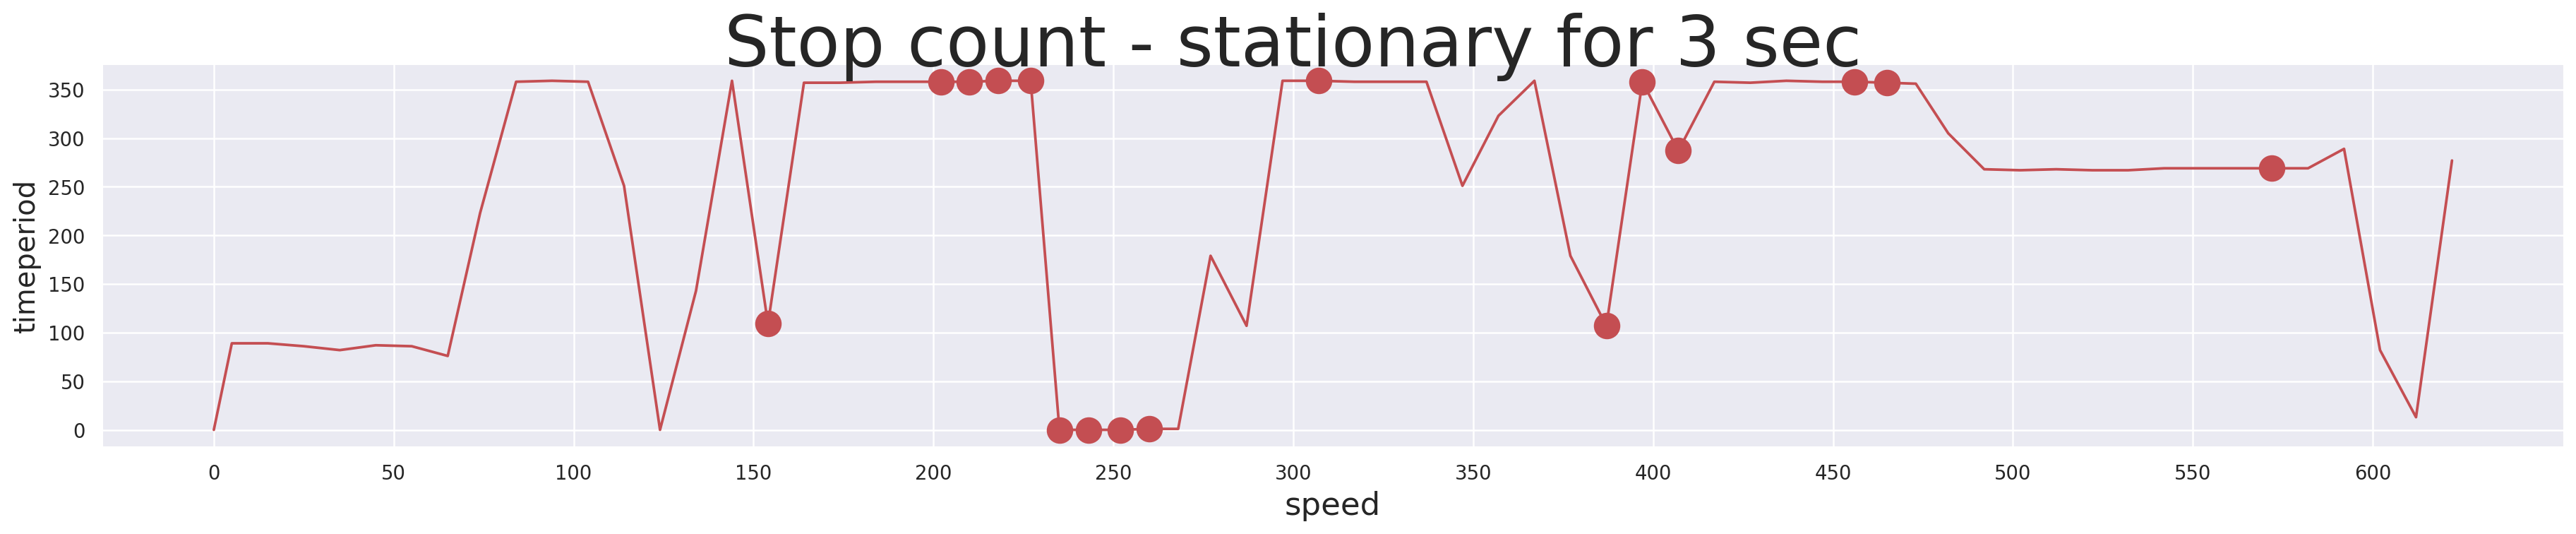

In [ ]:
import numpy as np
from matplotlib.pyplot import figure

markers_on = list(data2["turn_count"].values)
fig = plt.figure(num=None, figsize=(25, 4), dpi=180, facecolor='w', edgecolor='k')
fig.suptitle('Turn count - changed 45deg in 3 sec ', fontsize=40)
plt.xlabel('degree turn', fontsize=18)
plt.ylabel('timeperiod', fontsize=16)
plt.xticks(np.arange(min(data2['time_seconds']), max(data2['time_seconds'])+1, 50.0))
plt.plot(data2['time_seconds'],data2['heading_degrees'],markevery=markers_on, ls='-', ms=14, marker='o')
plt.show()

markers_on2 = list(data2["stop_count"].values)
fig = plt.figure(num=None, figsize=(25, 4), dpi=180, facecolor='w', edgecolor='k')
fig.suptitle('Stop count - stationary for 3 sec', fontsize=40)
plt.xlabel('speed', fontsize=18)
plt.ylabel('timeperiod', fontsize=16)
plt.xticks(np.arange(min(data2['time_seconds']), max(data2['time_seconds'])+1, 50.0))
plt.plot(data2['time_seconds'],data2['heading_degrees'],markevery=markers_on2, ls='-', ms=14, marker='o',color='r')
plt.show()

Saving model_data_train_features.csv to model_data_train_features (25).csv


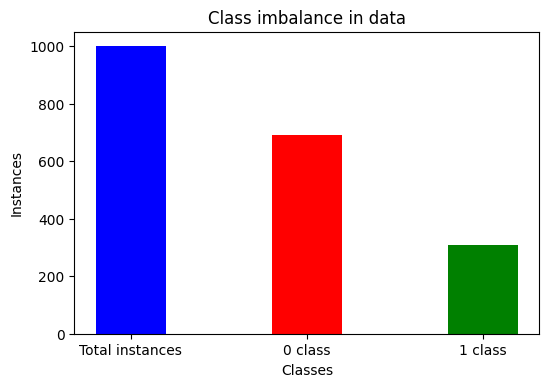

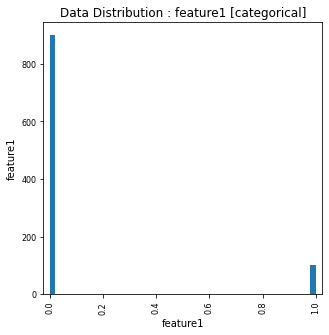

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


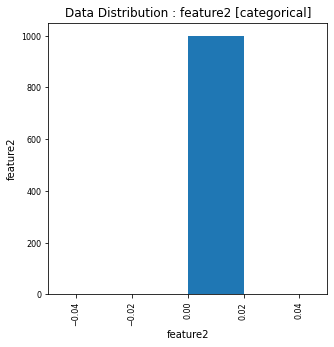

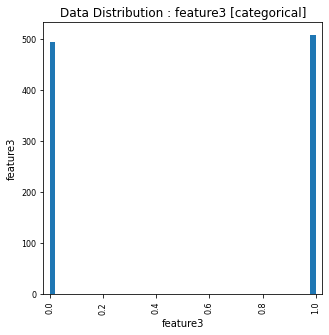

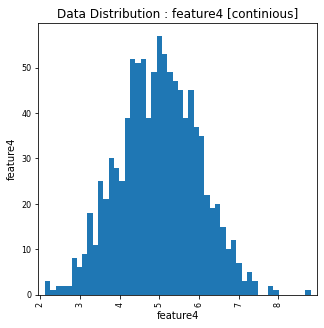

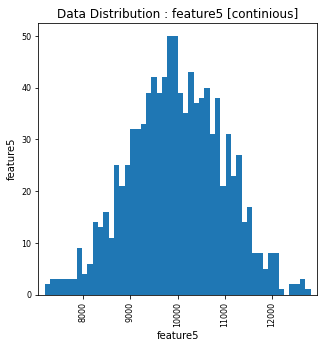

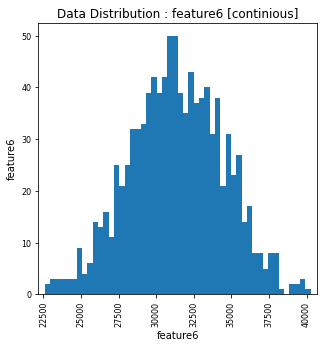

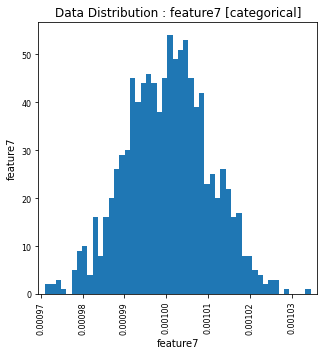

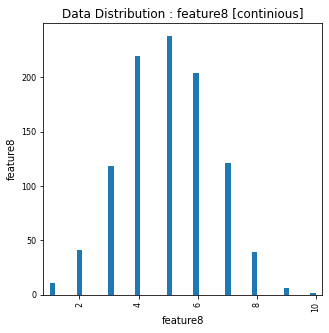

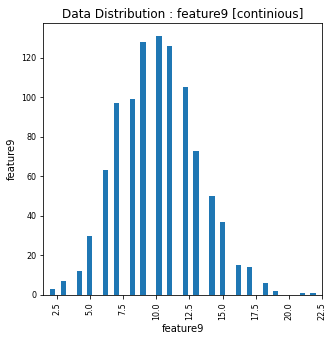

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


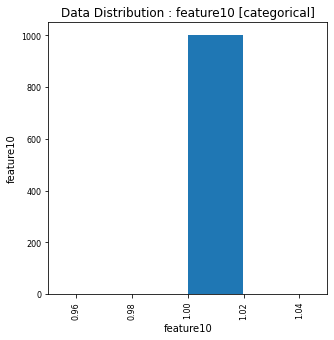

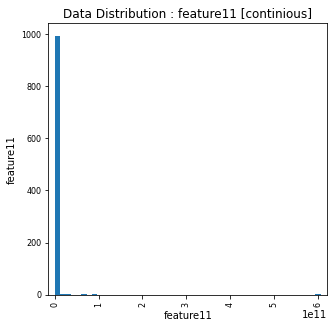

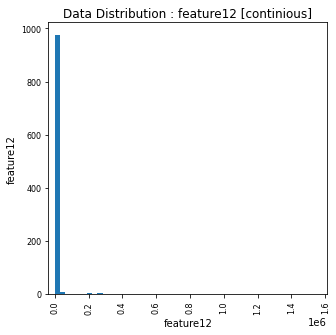

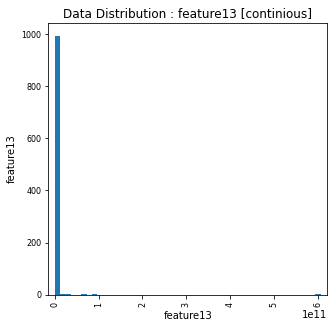

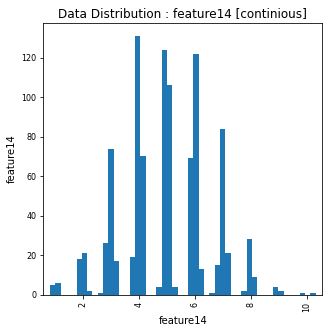

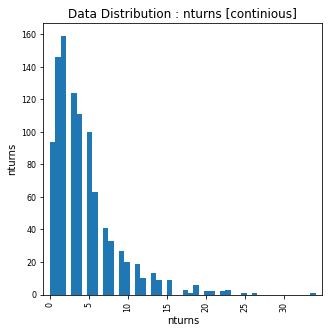

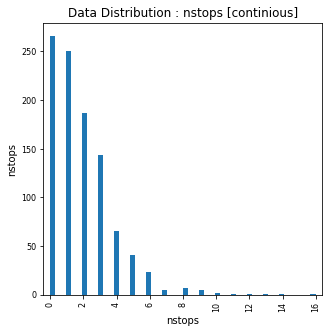

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
import numpy as np
from google.colab import files
import io

uploaded = files.upload()
processed_data = pd.read_csv(io.BytesIO(uploaded['model_data_train_features.csv']))

def data_eda_preprocess(data):
  data.drop(columns=['Unnamed: 0', 'filename'], inplace=True)
  # data=pd.concat([data[data.y == 0].sample(frac=1),data[data.y==1]],axis=0)
  val=[  len(data),len(data[data.y == 0]),  len(data[data.y == 1])]
  data.replace({False: 0, True: 1}, inplace=True)
  plt.bar(["Total instances", "0 class","1 class"], val, color =['blue','red','green']  
        ,width = 0.4) 
  plt.xlabel("Classes") 
  plt.ylabel("Instances") 
  plt.title("Class imbalance in data") 
  plt.show() 

  X = data[
        ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9',
         'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'nturns', 'nstops']]
  Y = data[["y"]]
  
  for col in X.columns:
    rr = pd.plotting.scatter_matrix(X[[col]], c=Y, figsize=(5, 5), marker='o',
                                  hist_kwds={'bins': 50}, s=60, alpha=.8)
    typ=""
    try:
      z=len(X[col].astype(int).unique())
      if z <= 5:
        typ="categorical"
      else:
        typ="continious"
      plt.title("Data Distribution : "+str(col)+" ["+typ+"]" )
      plt.show()
    except:
      continue
data_eda_preprocess(processed_data)

In [ ]:
def model():
    

    

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    '''model_std = StandardScaler()
    X_train = model_std.fit_transform(X_train)
    X_test=model_std.fit_transform(X_test)'''
    param = {
        'scale_pos_weight': 1.22,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }
    scoring = ['precision_macro', 'recall_macro','f1','balanced_accuracy']
    model_xgboost = XGBClassifier(learning_rate=0.001,
                          n_estimators=100,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=1,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=2.22,
                          seed=27,verbosity=0)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    results = cross_validate(model_xgboost, X_train, y_train, cv=kfold,verbose=0,scoring=scoring)

    print([(i,np.mean(results[i])*100) for i  in results])

    model_rf=RandomForestClassifier(verbose=0)
    kfold2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    results2 = cross_validate(model_rf, X_train, y_train, cv=kfold2,scoring=scoring)
    print("\n","Xgboost : ",[{i:np.mean(results2[i])*100} for i  in results2])

    model3=RandomForestClassifier(verbose=0,n_estimators=1000)
    model3.fit(X_train,y_train)
    pred=model3.predict(X_test)
    print("\n","RandomForest : ", balanced_accuracy_score(y_test,pred),f1_score(y_test,pred))

    model4 = RFE(model3, n_features_to_select=7, step=1)
    model4.fit(X_train, y_train)
    pred = model4.predict(X_test)
    print("\n","RandomForest with RFE: ",balanced_accuracy_score(y_test, pred), f1_score(y_test, pred))
model()
